# 02. Exploratory Analysis - Nubank AI Core Transaction Dataset Interview Project

This is the continuation of the exploratory analysis of the Nubank project dataset. This notebook will continue to look at other features of the dataset, namely the `Amount`, `Trasaction Date` and `Posted Date` columns.

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_theme()
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#8A05BE", "#A5D936", "#191919"])


In [2]:
df = pd.read_csv('./nubank_checkpoint_01.csv')

In [3]:
df.head()

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,96.39,WAL-MART #0137,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"GROCERY STORES,AND SUPERMARKETS"
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,125.96,STAPLES DIRECT,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT..."


In [4]:
def clean_discrepant_names(df: pd.DataFrame):
    discrepant_names_df = pd.DataFrame(df.groupby(['Agency Number'])['Agency Name'].unique()).reset_index()
    discrepant_names = discrepant_names_df[discrepant_names_df['Agency Name'].apply(lambda x: len(x) > 1)].copy()
    # this may not be the best way to select the names, but 
    # saves us from having to manually check the names and hard code the desired outputs
    discrepant_names['Correct Name'] = [name[0] for name in discrepant_names['Agency Name']]
    for agency_number in discrepant_names['Agency Number']:
        correct_name = discrepant_names.loc[discrepant_names['Agency Number'] == agency_number, 'Correct Name'].values[0]
        df.loc[df['Agency Number'] == agency_number, 'Agency Name'] = correct_name
    return df

In [5]:
def clean_dates(df: pd.DataFrame):
    # clean dates that are not in the format YYYY/MM/DD
    df.dropna(subset=['Transaction Date'], inplace=True)
    df['Transaction Date'] = df['Transaction Date'].apply(lambda x: x if '/' in x else None)
    df.dropna(subset=['Transaction Date'], inplace=True)
    df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
    return df

In [6]:
df = clean_discrepant_names(df)
df = clean_dates(df)

In [7]:
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
df['Posted Date'] = pd.to_datetime(df['Posted Date'])
df['Amount'] = df['Amount'].apply(lambda x: str(x).strip("$()").replace(",", "")).astype(float)

In [8]:
df.head()

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,SHERATON
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,165.82,SEARS.COM 9300,2013-07-29,2013-07-31,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,96.39,WAL-MART #0137,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS"
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,125.96,STAPLES DIRECT,2013-07-30,2013-07-31,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT..."


## 3. Amount

We've seen from the last notebook that the amount feature is pretty bottom heavy, with some very discrepant values in the millions that make the distribution pretty weird. Most of the values are in the hundreds and thousands, but a few samples contain values in the hundreds of thousands to millions.

To fix this issue when training the model, we'll apply a logarithmic scale to the amount values and then quantize them for a classification task downstream.

Since we've removed the negative values (refunds) from the dataset, applying a logarithmic scale won't cause any troubles. However, if we ever consider using the refund values downstream for any models, we should keep this in mind.


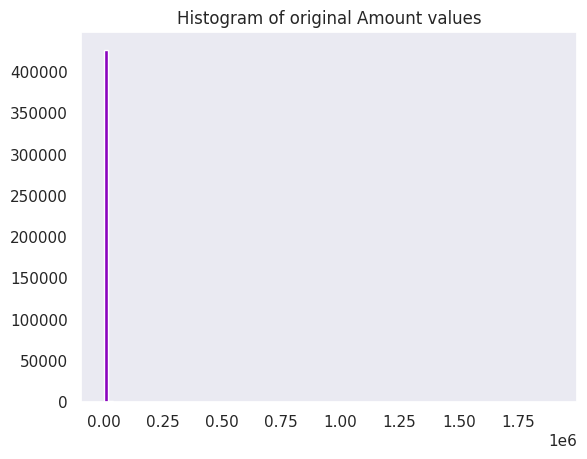

In [9]:
fig = plt.figure()
plt.grid(False)
plt.hist(df['Amount'], bins=100)
plt.title('Histogram of original Amount values')
fig.savefig('./images/histogram_amount_original_values.png')

As we can see, even with 100 bins we still get some pretty weird distribution due to magnitude of difference in the amount samples.

In [10]:
import numpy as np
import math

def quantize(data: np.ndarray, num_bins: int, min_value: float = 0.01, max_value: float = 1e7):
    log_min = math.log1p(min_value)
    log_max = math.log1p(max_value)
    bin_edges = np.logspace(log_min, log_max, num=num_bins+1, base=math.e) - 1
    bin_edges = np.concatenate([[-np.inf], [0], bin_edges, [np.inf]])

    def _quantize(x):
        if x < 0:
            return 0  # bin for negative values (refunds)
        elif x == 0:
            return 1  # bin for zero values
        else:
            return np.digitize(x, bin_edges) - 1
    quant_inputs = np.array([_quantize(x) for x in data])
    return quant_inputs, bin_edges

num_bins = 20
    
quant_inputs, bin_edges = quantize(df['Amount'], num_bins=num_bins)

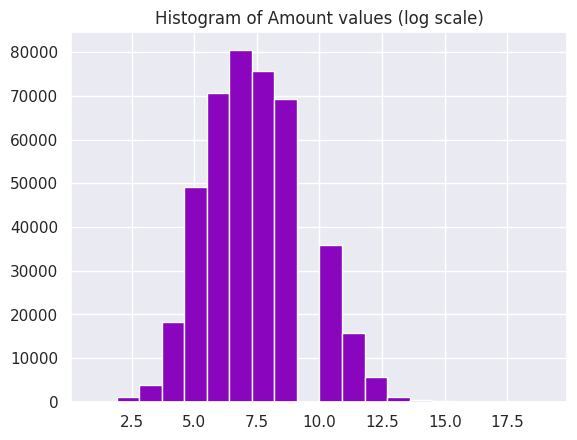

In [11]:
df['Original Amount'] = df['Amount']
df['Amount'] = quant_inputs

fig = plt.figure()
plt.hist(df['Amount'], bins=num_bins)
plt.title('Histogram of Amount values (log scale)')
fig.savefig('./images/histogram_amount_values_log.png')

With this scaling, we can get a much nicer distribution. However, it's still somewhat of a normal distribution. This may be a problem for our training since we have much more data points in the ~4 to ~ 12 range of the distrbution

We should consider upsampling these points.

Let's also create a reverse function that computes our bins in dollar amounts so we can decode later.

In [12]:
def decode_quantized_amount(quantized_value: int, bin_edges: np.ndarray) -> tuple[float, float]:
    if quantized_value == 0:
        return -1.0, -1.0
    elif quantized_value == 1:
        return 0.0, 0.0
    else:
        lower_bound = bin_edges[quantized_value]
        upper_bound = bin_edges[quantized_value + 1]
        return lower_bound, upper_bound

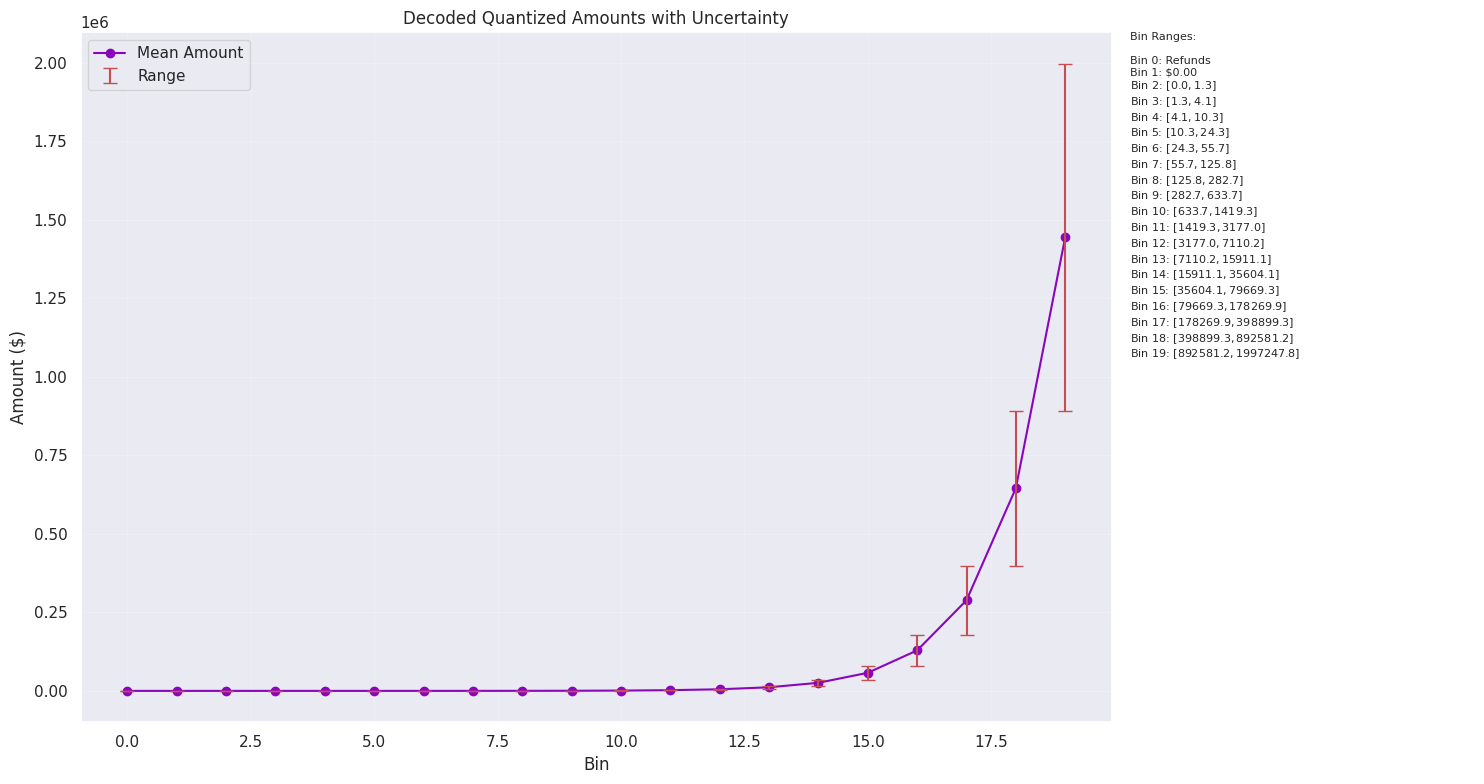

In [13]:
lower_bounds = []
upper_bounds = []
means = []
for i in range(num_bins):
    lower, upper = decode_quantized_amount(i, bin_edges)
    lower_bounds.append(lower)
    upper_bounds.append(upper)
    means.append((lower + upper) / 2 if lower != upper else lower)

figsize=(15, 8)
fig, (ax, ax_legend) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [3, 1]})
bins = range(num_bins)
ax.plot(bins, means, 'o-', label='Mean Amount')
ax.errorbar(bins, means, yerr=[np.array(means) - np.array(lower_bounds), 
                               np.array(upper_bounds) - np.array(means)], 
            fmt='none',  ecolor='r', capsize=5, label='Range')
ax.set_xlabel('Bin')
ax.set_ylabel('Amount ($)')
ax.set_title('Decoded Quantized Amounts with Uncertainty')
ax.legend()
ax.grid(True, which="both", ls="-", alpha=0.2)

ax_legend.axis('off')
legend_text = "Bin Ranges:\n\n"
for i in range(num_bins):
    lower, upper = decode_quantized_amount(i, bin_edges)
    if i == 0:
        legend_text += f"Bin {i}: Refunds\n"
    elif i == 1:
        legend_text += f"Bin {i}: $0.00\n"
    else:
        legend_text += f"Bin {i}: [${lower:.1f},  ${upper:.1f}]\n"
ax_legend.text(0, 1, legend_text, verticalalignment='top', fontsize=8)

plt.tight_layout()
plt.show()
fig.savefig('./images/decoded_quantized_amounts.png')

Through this quantization, we can better discretize the dollar amounts. Although it's not the ideal discretization, this method allows us to have a common ground distribution if we ever do fine-tuning/evaluations on out-of-distribution samples. We can also try different `num_bins` values as a hyperparameter.

Also, intuitively this kinda makes sense. We should expect a finer control of smaller values because we have more data to model it, while larger values are intrinsically more uncertain due to less samples. 

## Dates

Let's take a look at our dates and see what we can extract from them.

In [14]:
print("-"*50)
print("Transaction dates:")
print(f"Unique Transaction Dates: {len(df['Transaction Date'].unique())}")
print(f"Min Transaction Date: {df['Transaction Date'].min()}")
print(f"Max Transaction Date: {df['Transaction Date'].max()}")
print("-"*50)
print("Posted dates:")
print(f"Unique Posted Dates: {len(df['Posted Date'].unique())}")
print(f"Min Posted Date: {df['Posted Date'].min()}")
print(f"Max Posted Date: {df['Posted Date'].max()}")
print("-"*50)

--------------------------------------------------
Transaction dates:
Unique Transaction Dates: 377
Min Transaction Date: 2013-05-16 00:00:00
Max Transaction Date: 2014-06-30 00:00:00
--------------------------------------------------
Posted dates:
Unique Posted Dates: 258
Min Posted Date: 2013-07-01 00:00:00
Max Posted Date: 2014-06-30 00:00:00
--------------------------------------------------


Since this dataset is supposed to be the transaction data from the second semester of 2013 through the end of the first semester of 2014, these transaction dates before 2013-07 are probably because the dataset considers the posted date as the index for saving these transactions into the dataset. Let's see how many samples have transaction dates before that date.

In [15]:
len(df[df['Transaction Date'] < pd.to_datetime('2013-07')])

2676

In [16]:
df[df['Transaction Date'] < pd.to_datetime('2013-07')].head()

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC),Original Amount
1428,201307,1000,OKLAHOMA STATE UNIVERSITY,Chapman,M,8,QUILL CORPORATION,2013-06-28,2013-07-02,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...",184.25
1532,201307,1000,OKLAHOMA STATE UNIVERSITY,Gibson,J,7,CHEEZIES PIZZA,2013-06-30,2013-07-02,FAST FOOD RESTAURANTS,74.85
1539,201307,1000,OKLAHOMA STATE UNIVERSITY,Hall,S,4,NAPA AUTO PARTS,2013-06-29,2013-07-02,AUTOMOTIVE PARTS AND ACCESSORIES STORES,8.02
1540,201307,1000,OKLAHOMA STATE UNIVERSITY,Hanson,C,7,QUILL CORPORATION,2013-06-28,2013-07-02,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...",78.69
1544,201307,1000,OKLAHOMA STATE UNIVERSITY,Haseley,S,6,U-HAUL STILLWATER,2013-06-30,2013-07-02,TRUCK AND UTILITY TRAILER RENTALS,42.80


This also confirms that the Year-Month column is following the Posted Date.

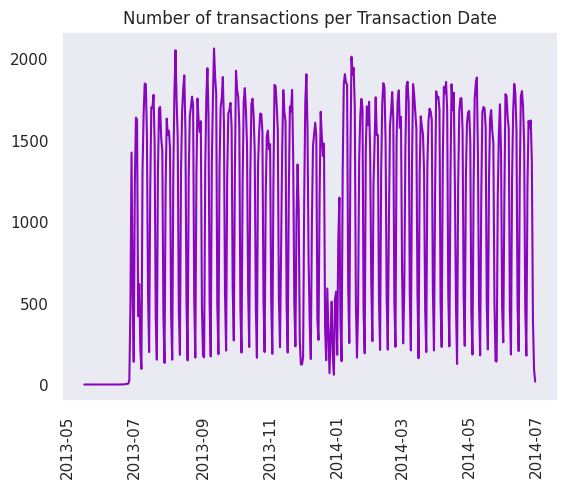

In [17]:
transaction_dates = pd.DataFrame(df.groupby('Transaction Date').size())
fig = plt.figure()
plt.grid(False)
plt.plot(transaction_dates[0])
plt.xticks(rotation='vertical')
plt.title('Number of transactions per Transaction Date')
fig.savefig('./images/num_transactions_per_transaction_date')

Our new transaction dates also have a little bit of seasonality to them, which is expected. We can try upsampling these dates as well, but I think this intrisic seasonal nature of the data is also interesting for our model to learn.

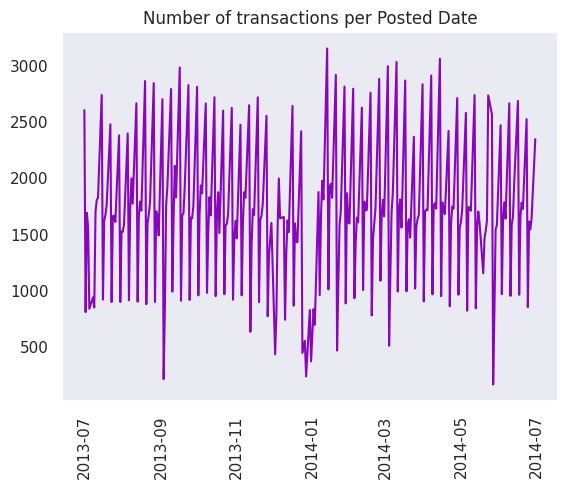

In [18]:
posted_dates = pd.DataFrame(df.groupby('Posted Date').size())
fig = plt.figure()
plt.grid(False)
plt.plot(posted_dates[0])
plt.xticks(rotation='vertical')
plt.title('Number of transactions per Posted Date')
fig.savefig('./images/num_transactions_per_posted_date')

That's pretty interesting. It seems that the seasonality of the Posted Date is slightly different from the Transaction Date. Maybe it's a week-day thing in which the government workers tend to post things in bulk in specific days of the week? Let's see.

In [19]:
posted_dates.reset_index(inplace=True)
transaction_dates.reset_index(inplace=True)
posted_dates.rename(columns={0:'Count'}, inplace=True)
transaction_dates.rename(columns={0:'Count'}, inplace=True)

In [20]:
WEEKDAY_MAPPING = {0: '0 - Monday', 1: '1 - Tuesday', 2: '2 - Wednesday', 3: '3 - Thursday', 4: '4 - Friday', 5: '5 - Saturday', 6: '6 - Sunday'}
posted_dates['Weekday'] = posted_dates['Posted Date'].apply(lambda x: WEEKDAY_MAPPING[x.weekday()])
transaction_dates['Weekday'] = transaction_dates['Transaction Date'].apply(lambda x: WEEKDAY_MAPPING[x.weekday()])

In [21]:
weekday_counts = posted_dates[['Posted Date', 'Weekday']].groupby('Weekday').sum(numeric_only=True)

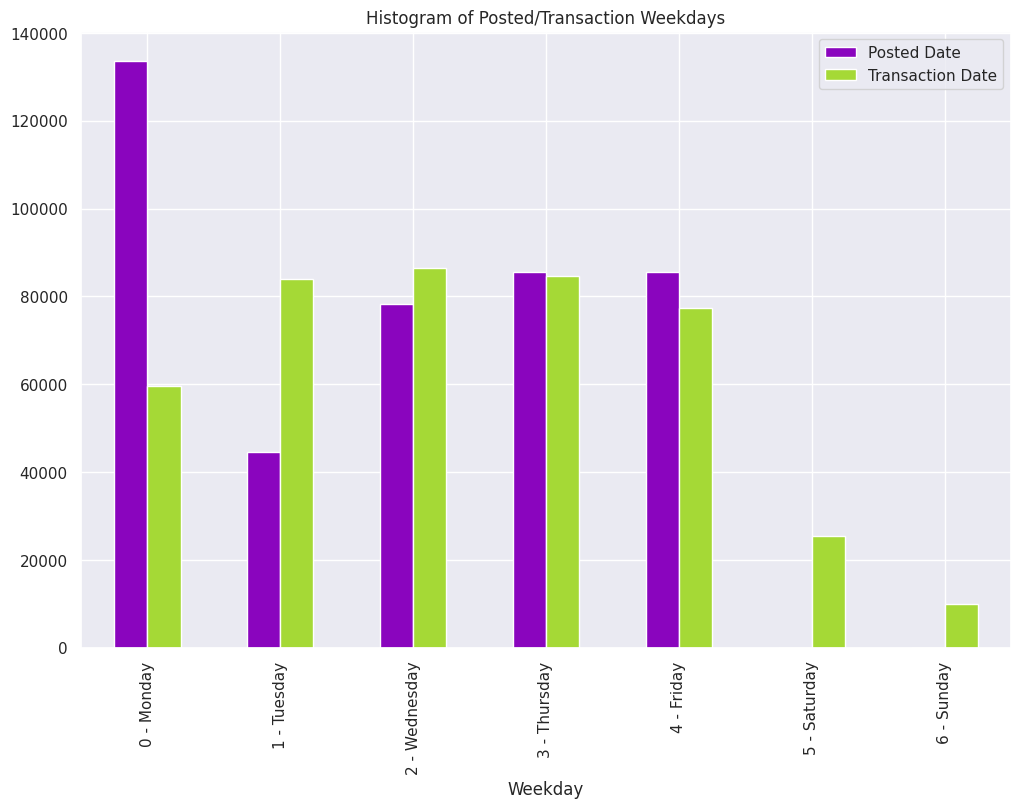

In [22]:
figsize = (12,8)
fig, ax = plt.subplots(figsize=figsize)
weekday_counts = posted_dates[['Count', 'Weekday']].groupby('Weekday').sum(numeric_only=True)
weekday_counts = weekday_counts.join(
    transaction_dates[['Count', 'Weekday']].groupby('Weekday').sum(numeric_only=False),
    how='right',
    on='Weekday', lsuffix='Posted', rsuffix='Transaction').set_index('Weekday')
weekday_counts.plot.bar(ax=ax)
plt.title('Histogram of Posted/Transaction Weekdays')
plt.legend(['Posted Date', 'Transaction Date'])
plt.xticks(rotation='vertical')
fig.savefig('./images/dates_per_weekday_transaction_vs_posted.png')

Yeah, the Posted date has only values on weekdays but never weekends. The transaction dates reflects the true date of the transaction. Although the volume of transactions on weekends is a lot lower than the rest of the days, it still accounts for some percentage of values.

Let's see if the mean transaction value is different for each of these dates, maybe there's some alpha to adding the weekday to the dataset.

In [23]:
df['Weekday'] = df['Transaction Date'].apply(lambda x: WEEKDAY_MAPPING[x.weekday()])
original_amount_per_weekday = df[['Weekday', 'Original Amount']].groupby('Weekday').agg({'Original Amount': ['mean', 'std']})
amount_per_weekday = df[['Weekday', 'Amount']].groupby('Weekday').agg({'Amount': ['mean', 'std']})

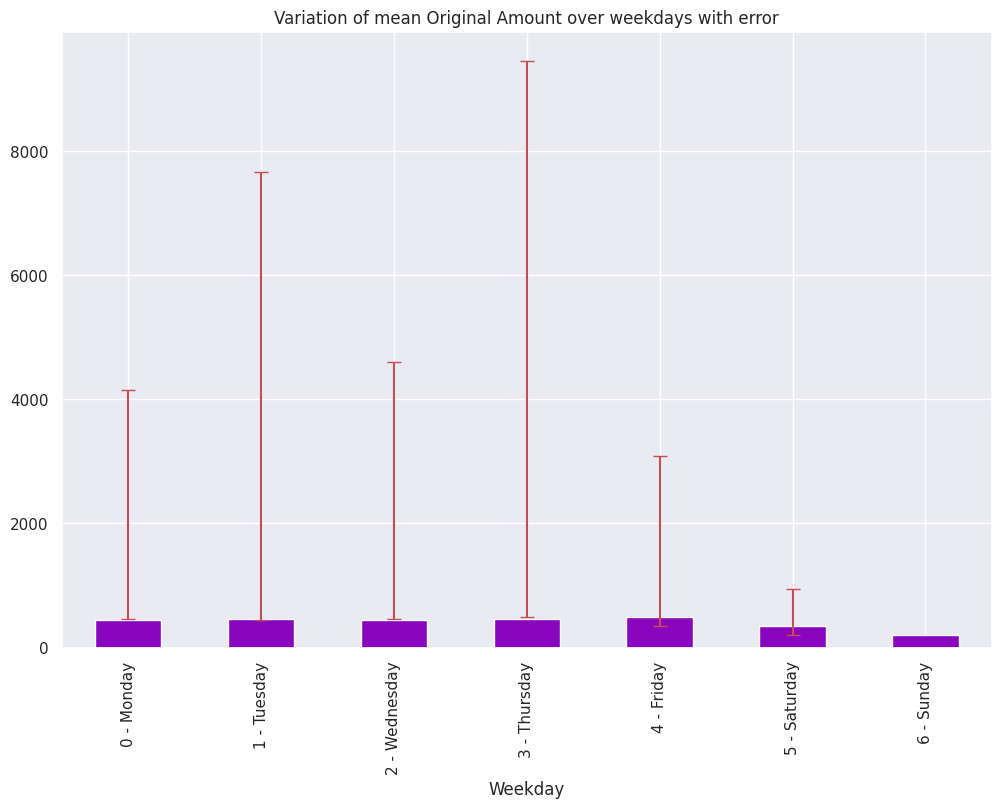

In [24]:
fig, ax = plt.subplots(figsize=(12,8))
means = original_amount_per_weekday['Original Amount', 'mean']
stds = original_amount_per_weekday['Original Amount', 'std']
mins = np.clip(np.array(means) - np.array(stds), 0, None)
means.plot.bar(ax=ax)
min_x, max_x = ax.get_xlim()
x_positions = np.arange(min_x, max_x, (max_x - min_x)/7) + min_x
ax.errorbar(x_positions, means, yerr=[mins, 
                               np.array(means) + np.array(stds)], 
            fmt='none',  ecolor='r', capsize=5, label='Range')

plt.title('Variation of mean Original Amount over weekdays with error')
fig.savefig('./images/variation_of_mean_original_amount_over_weekdays_with_error.png')

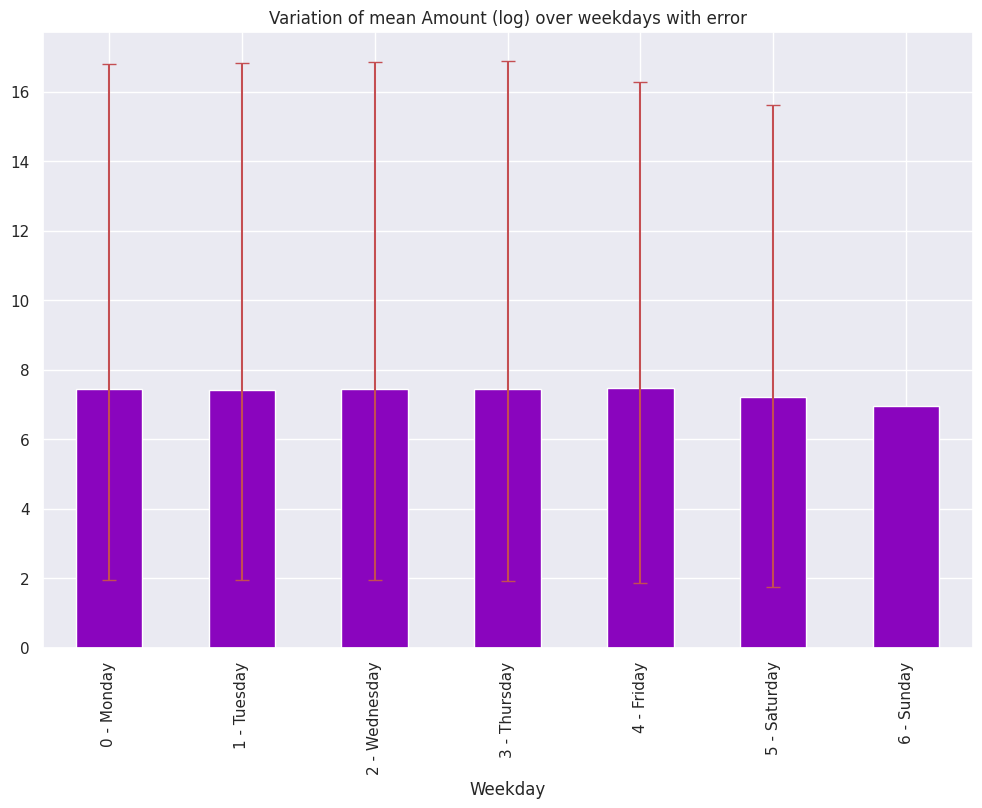

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
means = amount_per_weekday['Amount', 'mean']
stds = amount_per_weekday['Amount', 'std']
mins = np.clip(np.array(means) - np.array(stds), 0, None)
means.plot.bar(ax=ax)
min_x, max_x = ax.get_xlim()
x_positions = np.arange(min_x, max_x, (max_x - min_x)/7) + min_x
ax.errorbar(x_positions, means, yerr=[mins, 
                               np.array(means) + np.array(stds)], 
            fmt='none',  ecolor='r', capsize=5, label='Range')
plt.title('Variation of mean Amount (log) over weekdays with error')
fig.savefig('./images/variation_of_mean_amount_over_weekdays_with_error.png')

Except for Sundays, the distribution seems to be more or less the same. I don't think there's much alpha in adding these weekdays to the dataset.

That was a bit of a tangent. What we can figure out from this is that if we had to choose one date that should be included in the modelling, it should be the Transaction Date because it reflects the real sample date.

Let's strip these values from the dataset so we work with cleaner samples. Also, let's strip the samples that are before our actual start date of 2013-07.

In [26]:
df = df.drop(columns=['Year-Month', 'Posted Date', 'Weekday'])
df = df[df['Transaction Date'] > pd.to_datetime('2013-07')]
df.head()

,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Amount,Vendor,Transaction Date,Merchant Category Code (MCC),Original Amount
0,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,10,NACAS,2013-07-30,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,890.00
1,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,9,SHERATON HOTEL,2013-07-30,SHERATON,368.96
2,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,8,SEARS.COM 9300,2013-07-29,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,165.82
3,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,7,WAL-MART #0137,2013-07-30,"GROCERY STORES,AND SUPERMARKETS",96.39
4,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,8,STAPLES DIRECT,2013-07-30,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...",125.96


Another thing that is relevant is that these samples are constrained to a specific time frame (2013-2014). If we want to achieve generalization, training on the pure text representations of the dates may not be a good idea, as the model will learn features only for this specific timeframe. If we try to fine-tune or predict it downstream for samples on 2015 for example, this representation may be lost.

Therefore, what we can do is encode these values as categorical (much like we did with Amount), representing which section of the day/week/month/year it's referring to. Let's take a look at the number of transactions per week and see if this discretization will suffice.

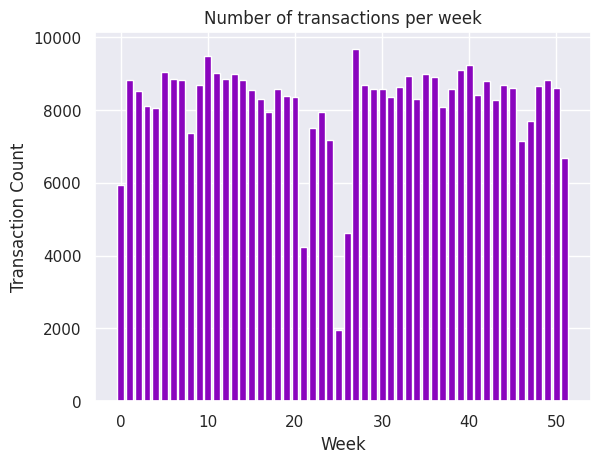

In [27]:
df['Timestamp'] = pd.to_datetime(df['Transaction Date']) - pd.to_timedelta(7, unit='d')
transactions_per_week = df.groupby([pd.Grouper(key='Timestamp', freq='W-MON')]).size().reset_index().sort_values('Timestamp')
fig = plt.figure()
plt.bar(range(52), transactions_per_week[0])
plt.xlabel('Week')
plt.ylabel('Transaction Count')
plt.title('Number of transactions per week')
fig.savefig('./images/transactions_per_week.png')

The idea here is to create create bins for each week and quantize them into a value between 0 and 51. This may also be a hyperparameter to test later, but for now let's stick to a per-week-basis.

In [28]:
df['Timestamp'] = df.groupby(pd.Grouper(key='Timestamp', freq='W-MON')).ngroup()

In [29]:
df

,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Amount,Vendor,Transaction Date,Merchant Category Code (MCC),Original Amount,Timestamp
0,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,10,NACAS,2013-07-30,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,890.00,4
1,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,9,SHERATON HOTEL,2013-07-30,SHERATON,368.96,4
2,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,8,SEARS.COM 9300,2013-07-29,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,165.82,3
3,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,7,WAL-MART #0137,2013-07-30,"GROCERY STORES,AND SUPERMARKETS",96.39,4
4,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,8,STAPLES DIRECT,2013-07-30,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...",125.96,4
...,...,...,...,...,...,...,...,...,...,...
427645,98000,GRAND RIVER DAM AUTH.,Cardholder,e,10,TOTAL VALVE SYSTEMS,2014-06-20,HARDWARE EQUIPMENT AND SUPPLIES,992.00,50
427646,98000,GRAND RIVER DAM AUTH.,Cardholder,e,11,PRYOR WASTE & RECYCLING L,2014-06-20,"UTILITIES - ELECTRIC,GAS,WATER,SANITARY",2415.00,50
427647,98000,GRAND RIVER DAM AUTH.,Cardholder,e,8,ACCURATE ENVIROMENTAL LAB,2014-06-20,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,177.50,50
427648,98000,GRAND RIVER DAM AUTH.,Cardholder,e,14,RED BUD SERVICE INC,2014-06-19,PROFESSIONAL SERVICES NOT ELSEWHERE CLASSIFIED,32457.00,50


### 4. Cardholder names

This field is a bit tricky because it requires some ethical considerations. On one hand, including the Cardholder Last Name in the modelling may give some better results if for example some more expensive transactions are only done by more senior people, guaranteeing a more discretized modelling. On the other hand, including these names may include unwanted biases in the model (for example foreign names). Also, including personal identifiable information in the modelling/dataset may be against LGPD rules.

Either way, let's analyze to see if there's any interesting information in this column.

In [30]:
len(df['Cardholder Last Name'].unique())

3897

There are some cases where the Cardholder's names are numeric. Are they outliers/badly parsed data?

In [31]:
df[df['Cardholder Last Name'].str.isnumeric()]

,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Amount,Vendor,Transaction Date,Merchant Category Code (MCC),Original Amount,Timestamp
92443,24100,REDLANDS COMMUNITY COLLEGE,24100,2,5,PURCHASE FINANCE CHARGE,2013-07-15,OTHER FEES,16.90,1
92452,24100,REDLANDS COMMUNITY COLLEGE,24100,2,11,LATE PAYMENT FEE,2013-07-25,OTHER FEES,1796.09,3
92510,24100,REDLANDS COMMUNITY COLLEGE,24100,2,5,PURCHASE FINANCE CHARGE,2013-08-15,OTHER FEES,14.53,6
92530,24100,REDLANDS COMMUNITY COLLEGE,24100,2,10,LATE PAYMENT FEE,2013-08-26,OTHER FEES,734.50,7
92607,24100,REDLANDS COMMUNITY COLLEGE,24100,2,4,PURCHASE FINANCE CHARGE,2013-09-13,OTHER FEES,6.54,10
92723,24100,REDLANDS COMMUNITY COLLEGE,24100,2,2,PURCHASE FINANCE CHARGE,2013-12-13,OTHER FEES,0.04,23
92737,24100,REDLANDS COMMUNITY COLLEGE,24100,2,8,LATE PAYMENT FEE,2013-12-26,OTHER FEES,250.00,25
92766,24100,REDLANDS COMMUNITY COLLEGE,24100,2,2,PURCHASE FINANCE CHARGE,2014-01-15,OTHER FEES,0.77,28
117802,42000,LANGSTON UNIVERSITY,42000,4,2,PURCHASE FINANCE CHARGE,2013-07-04,OTHER FEES,1.17,0
117854,42000,LANGSTON UNIVERSITY,42000,4,9,LATE PAYMENT FEE,2013-08-14,OTHER FEES,350.21,6


I guess not, they are just payments on the name of the agency instead of a person.

In [32]:
df['Cardholder Name'] = df.apply(lambda x: f"{x['Cardholder First Initial'].upper()}. {x['Cardholder Last Name'].upper()}", axis=1) 

In [33]:
len(df['Cardholder Name'].unique())

5007

Are there any individuals that make transactions for more than one agency?

In [34]:
cardholders = df[['Agency Name', 'Cardholder Name']].groupby('Cardholder Name')['Agency Name'].apply(lambda x: list(x.unique())).reset_index(name='Agency List')

In [35]:
cardholders['Size'] = cardholders['Agency List'].apply(lambda x: len(x))

In [36]:
cardholders

,Cardholder Name,Agency List,Size
0,1. 15000,[UNIV.OF SCIENCE & ARTS OF OK],1
1,2. 24100,[REDLANDS COMMUNITY COLLEGE],1
2,4. 42000,[LANGSTON UNIVERSITY],1
3,4. 44600,[MARGINALLY PROD. OIL & GAS WELLS],1
4,4. 48000,[N. E. OKLA. A & M COLLEGE],1
...,...,...,...
5002,Z. SUN,[UNIV. OF OKLA. HEALTH SCIENCES CENTER],1
5003,Z. WANG,[OKLAHOMA STATE UNIVERSITY],1
5004,Z. YANG,[OKLAHOMA STATE UNIVERSITY],1
5005,Z. ZEBARAUSKAITE,[OKLAHOMA STATE UNIVERSITY],1


In [37]:
cardholders[cardholders['Size'] > 1]

,Cardholder Name,Agency List,Size
24,A. BARNES,"[OKLAHOMA STATE UNIVERSITY, UNIVERSITY OF OKLA...",2
53,A. BROWN,"[ATTORNEY GENERAL, DEPARTMENT OF TRANSPORTATIO...",3
63,A. CARTER,"[OKLAHOMA STATE UNIVERSITY, UNIVERSITY OF OKLA...",2
93,A. EVANS,"[OKLA. PANHANDLE STATE UNIV., UNIVERSITY OF OK...",2
123,A. HAGGARD,"[STATE DEPARTMENT OF HEALTH, UNIVERSITY OF OKL...",2
...,...,...,...
4768,T. THOMAS,"[DEPARTMENT OF CORRECTIONS, OKLAHOMA STATE UNI...",2
4769,T. THOMPSON,"[OKLAHOMA STATE UNIVERSITY, DEPARTMENT OF VETE...",4
4788,T. WILLIAMS,"[DEPARTMENT OF CORRECTIONS, DEPARTMENT OF VETE...",3
4792,T. WRIGHT,"[GOVERNOR, DEPARTMENT OF WILDLIFE CONSERVATION]",2


<AxesSubplot: >

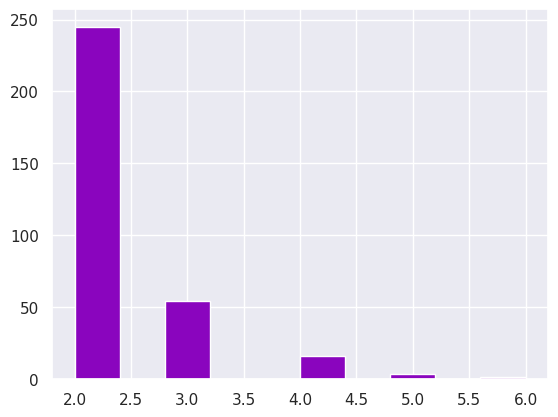

In [38]:
cardholders[cardholders['Size'] > 1]['Size'].hist()

Yeah, there aren't many cases where the same person makes a transaction for more than 1 agency, and when it happens it's usually only 1 more.

Let's look at the mean dollar amounts transacted by each person.

In [39]:
cardholders = df[['Agency Name', 'Cardholder Name', 'Original Amount']].groupby('Cardholder Name').agg({'Original Amount': ['mean', 'std', 'size']}).reset_index()

In [40]:
cardholders.iloc[cardholders['Original Amount', 'mean'].sort_values(ascending=False).index]

Cardholder Name Original Amount                   
                                mean           std size
9           7. 77000   913559.640000  1.056747e+06    4
8           7. 75000    29873.610000  2.046791e+02    2
922     C. STIERWALT    21230.366000  1.256874e+04   10
1636       G. HUNTER    16532.662667  3.240677e+04   45
4346       S. MECHAM    13641.879796  1.643253e+04   49
...              ...             ...           ...  ...
3039    L. WORCESTER        5.735000  1.746554e+00    2
1733      H. ELDOUMI        5.640000  3.726178e+00    6
4289       S. KANDEL        5.236667  3.139209e+00    3
6           5. 53100        0.400000  2.951271e-01    3
5           5. 53000        0.040000           NaN    1

[5007 rows x 4 columns]

It seems that there is *some* alpha to include the cardholder name on the modelling inputs. However, I believe the losses from including these biases on the model outweigh the gains that we might get, purely from a generalization perspective.

As opposed to fields such as MCC and Vendor, the cardholder field doesn't teach us very much about the data in general, and it might only be used to introduce biases towards the names. 

In [41]:
df = df.drop(columns=['Cardholder Last Name', 'Cardholder First Initial', 'Cardholder Name'])
df.head()

,Agency Number,Agency Name,Amount,Vendor,Transaction Date,Merchant Category Code (MCC),Original Amount,Timestamp
0,1000,OKLAHOMA STATE UNIVERSITY,10,NACAS,2013-07-30,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,890.00,4
1,1000,OKLAHOMA STATE UNIVERSITY,9,SHERATON HOTEL,2013-07-30,SHERATON,368.96,4
2,1000,OKLAHOMA STATE UNIVERSITY,8,SEARS.COM 9300,2013-07-29,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,165.82,3
3,1000,OKLAHOMA STATE UNIVERSITY,7,WAL-MART #0137,2013-07-30,"GROCERY STORES,AND SUPERMARKETS",96.39,4
4,1000,OKLAHOMA STATE UNIVERSITY,8,STAPLES DIRECT,2013-07-30,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...",125.96,4


Finally, the Agency Number is just an alias for the Agency Name. Since we're gonna apply tokenization to the text fields, keeping the agency number is redundant.

In [42]:
df = df.drop(columns=['Agency Number'])
df.head()

,Agency Name,Amount,Vendor,Transaction Date,Merchant Category Code (MCC),Original Amount,Timestamp
0,OKLAHOMA STATE UNIVERSITY,10,NACAS,2013-07-30,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,890.00,4
1,OKLAHOMA STATE UNIVERSITY,9,SHERATON HOTEL,2013-07-30,SHERATON,368.96,4
2,OKLAHOMA STATE UNIVERSITY,8,SEARS.COM 9300,2013-07-29,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,165.82,3
3,OKLAHOMA STATE UNIVERSITY,7,WAL-MART #0137,2013-07-30,"GROCERY STORES,AND SUPERMARKETS",96.39,4
4,OKLAHOMA STATE UNIVERSITY,8,STAPLES DIRECT,2013-07-30,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...",125.96,4


This seems like a good starting point for our dataset. Now we can start tokenizing and aggregating these values into sequence of transactions to train some models on top of it. 


Let's compile some statistics for the cleaning so far.

In [43]:
print(f"Dataframe size: {len(df)}")
print(f"Unique agencies: {len(df['Agency Name'].unique())}")
print(f"Unique vendors: {len(df['Vendor'].unique())}")
print(f"Unique transaction dates: {len(df['Transaction Date'].unique())}")
print(f"Unique MCCs: {len(df['Merchant Category Code (MCC)'].unique())}")
print(f"Max amount: {df['Original Amount'].max()}")
print(f"Min amount: {df['Original Amount'].min()}")


Dataframe size: 423743
Unique agencies: 115
Unique vendors: 84922
Unique transaction dates: 364
Unique MCCs: 433
Max amount: 1903858.4
Min amount: 0.01


In [44]:
df.to_csv('nubank_checkpoint_02.csv', index=False)